In [689]:
# Galsim trials
import sys
import os
import math
import logging
import galsim
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import time

In [690]:
logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger("demo5")

# Define some parameters we'll use below.
# Normally these would be read in from some parameter file.

nx_tiles = 3                   #
ny_tiles = 2                   #
stamp_xsize = 50                #
stamp_ysize = 50                #
size_x      = 150
size_y      = 90
random_seed = galsim.BaseDeviate(6424512).raw()
pixel_scale = 0.75               # arcsec / pixel
sky_level = 1.e7                # ADU / arcsec^2
gal_flux = 1.e-1   # counts
gal_r0   = 5.0    # arcsec
n_sources = 5

# Make output directory if not already present.
if not os.path.isdir('output'):
    os.mkdir('output')
psf_file_name = os.path.join('output','g08_psf.fits')
psf_beta = 3                    #
psf_fwhm = 2.85                 # arcsec (=pixels)
psf_trunc = 2.*psf_fwhm         # arcsec (=pixels)
psf_e1 = -0.019                 #
psf_e2 = -0.007                 #

gal_file_name = os.path.join('output','g08_gal.fits')
gal_signal_to_noise = 200 #200       # Great08 "LowNoise" run
gal_resolution = 2           # r_gal / r_psf (use r = half_light_radius)
gal_ellip_rms = 0.2             # using "distortion" definition of ellipticity:
                                #   e = (a^2-b^2)/(a^2+b^2), where a and b are the
                                #   semi-major and semi-minor axes, respectively.
gal_ellip_max = 0.6             # Maximum value of e, to avoid getting near e=1.
g1_vec = [0.1,0.2,0.5]
g2_vec = [0.5,0.4,0.2,0.2,0.2,0.2,0.6,0.7,0.8]
shift_radius = 10.0              # arcsec (=pixels)

# Define the PSF profile
psf = galsim.Moffat(beta=psf_beta, fwhm=psf_fwhm, trunc=psf_trunc)
psf_re = psf.half_light_radius
psf = psf.shear(e1=psf_e1,e2=psf_e2)
logger.debug('Made PSF profile')

# Define the galaxy profile

# First figure out the size we need from the resolution
gal_re = psf_re * gal_resolution

# Make the galaxy profile starting with flux = 1.
gal = galsim.Exponential(flux=gal_flux,half_light_radius=gal_re)
# This profile is placed with different orientations and noise realizations
# at each postage stamp in the gal image.
gal_image = galsim.ImageF(size_x , size_y, scale=pixel_scale)
psf_image = galsim.ImageF(size_x , size_y, scale=pixel_scale)

shift_radius_sq = shift_radius**2
first_in_pair = True  # Make pairs that are rotated by 90 degrees

center_x = np.ones(n_sources+1)
center_y = np.ones(n_sources+1)

k = 0
for idx in range(n_sources):

    ud = galsim.UniformDeviate(random_seed+k+1)
    gd = galsim.GaussianDeviate(ud, sigma=gal_ellip_rms)
    
    lower_x = int(idx * (size_x / n_sources) + 1)
    upper_x = int( lower_x + (size_x / n_sources) -2)
    
    # step = (size_x) / (2 * n_sources)
    # sequence = [round(i * step + 1) for i in range(n_sources)]   
    # lower_x = np.random.choice(sequence)
    # upper_x = int(lower_x + 2 * (size_x / n_sources)-2)
    
    step = (size_y) / (2 * n_sources)
    sequence = [round(i * step + 1) for i in range(n_sources)]   
    lower_y = np.random.choice(sequence)
    upper_y = int(lower_y + 2 * (size_y / n_sources)-2)
        
    print(f"upper x {upper_x} lower x {lower_x} upper y {upper_y} lower y {lower_y}")
        
    b = galsim.BoundsI(lower_x , upper_x,
                        lower_y , upper_y)
    
    # First figure out the size we need from the resolution
    gal_re = 2 

    # Make the galaxy profile starting with flux = 1.
    gal = galsim.Exponential(flux=gal_flux,half_light_radius=gal_re)
    
    # create the sub boxes
    sub_gal_image = gal_image[b]
    sub_psf_image = psf_image[b]

    # Apply the gravitational reduced shear by specifying g1/g2
    g1 = np.random.choice(g1_vec)          
    g2 = np.random.choice(g2_vec)                   
    this_gal = gal.shear(g1=g1, g2=g2)
    this_psf = psf

    # Make the final image, convolving with the (unshifted) psf
    final_gal = galsim.Convolve([psf,this_gal])

    # Draw the image
    final_gal.drawImage(sub_gal_image, add_to_image=True)
    this_psf.drawImage(sub_psf_image, add_to_image=True)

    x = b.center.x
    y = b.center.y
    center_x[idx] = x
    center_y[idx] = y
    logger.info('Galaxy (%d): center = (%.0f,%0.f)',
                idx,x,y)
    k = k+1
        
b = galsim.BoundsI(1 , size_x,
                    1 , size_y)
# First figure out the size we need from the resolution
gal_re = 6
# Make the galaxy profile starting with flux = 1.
gal = galsim.Exponential(flux=1,half_light_radius=gal_re)
# create the sub boxes
sub_gal_image = gal_image[b]
sub_psf_image = psf_image[b]

center_x[-1] = b.center.x
center_y[-1] = b.center.y

# Apply the gravitational reduced shear by specifying g1/g2
g1 = np.random.choice(g1_vec)          
g2 = np.random.choice(g2_vec)                
this_gal = gal.shear(g1=g1, g2=g2)
this_psf = psf

# Make the final image, convolving with the (unshifted) psf
final_gal = galsim.Convolve([psf,this_gal])

# Draw the image
final_gal.drawImage(sub_gal_image, add_to_image=True)
this_psf.drawImage(sub_psf_image, add_to_image=True)

upper x 29 lower x 1 upper y 44 lower y 10
Galaxy (0): center = (15,27)
upper x 59 lower x 31 upper y 53 lower y 19
Galaxy (1): center = (45,36)
upper x 89 lower x 61 upper y 53 lower y 19
Galaxy (2): center = (75,36)
upper x 119 lower x 91 upper y 62 lower y 28
Galaxy (3): center = (105,45)
upper x 149 lower x 121 upper y 53 lower y 19
Galaxy (4): center = (135,36)


galsim.Image(bounds=galsim.BoundsI(xmin=1, xmax=150, ymin=1, ymax=90), array=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), wcs=galsim.PixelScale(0.75))

Wrote PSF file output/g08_psf.fits
Wrote image to 'output/g08_gal.fits'


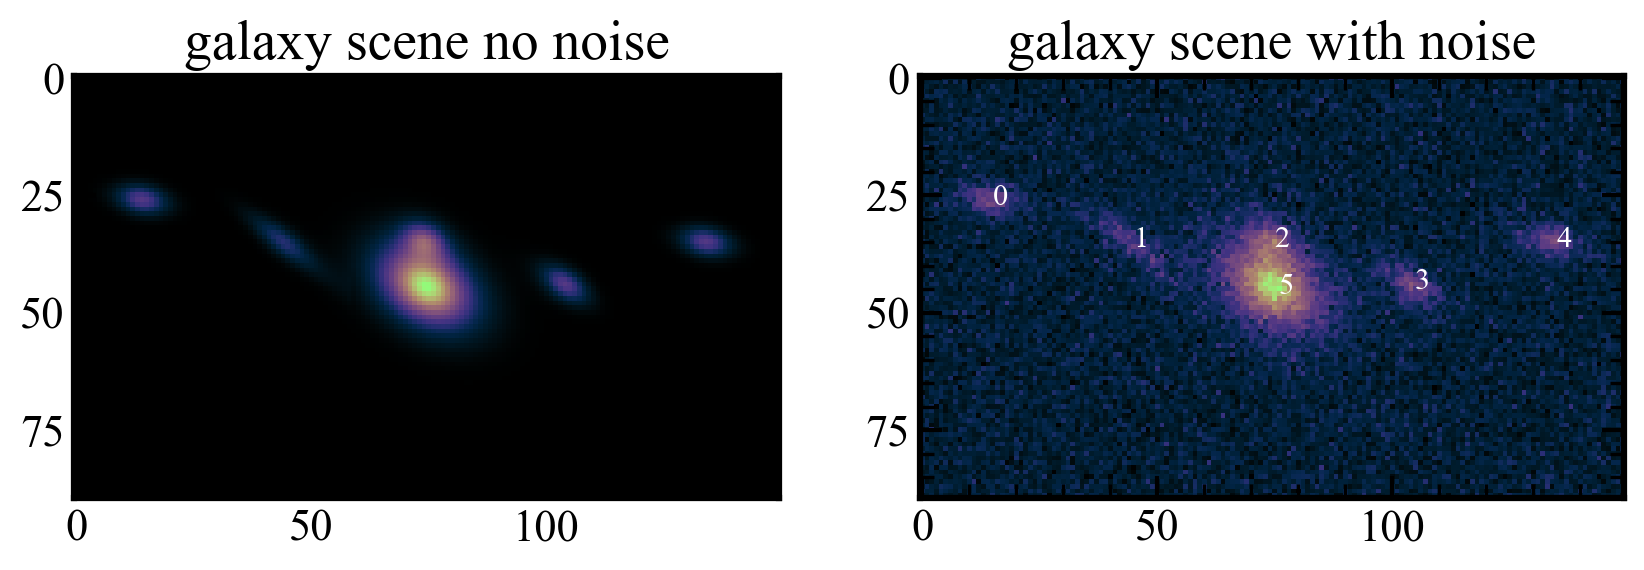

In [691]:
plt.subplot(1,2,1)
plt.imshow(gal_image.array, cmap = cmr.lilac)
plt.title('galaxy scene no noise',fontsize=20)
# annotate with source number
# for i in range(n_sources+1):
#     plt.text(center_x[i],center_y[i],str(i), c='white', fontsize=11)

ud = galsim.UniformDeviate(random_seed+k+1)
sky_level_pixel = 2.5e3 
noise = galsim.PoissonNoise(ud, sky_level=sky_level_pixel)
gal_image.addNoiseSNR(noise, gal_signal_to_noise)
psf_image.write(psf_file_name)
logger.info('Wrote PSF file %s',psf_file_name)
gal_image.write(gal_file_name)
logger.info('Wrote image to %r',gal_file_name)  # using %r adds quotes around filename for us

plt.subplot(1,2,2)
plt.imshow(gal_image.array, cmap = cmr.lilac)
plt.title('galaxy scene with noise',fontsize=20)
for i in range(n_sources+1):
    plt.text(center_x[i],center_y[i],str(i), c='white', fontsize=11)